In [1]:
#imports
import katdal
import numpy as np
import matplotlib.pylab as plt
import astropy.coordinates as ac
import functools
import healpy as hp
import optparse
import warnings
from matplotlib.backends.backend_pdf import PdfPages
import healpy as hp
from astropy import units as u
from matplotlib.offsetbox import AnchoredText
import time
import pickle
import sys
Tcmb=2.725
import katcali
import katcali.visualizer as kv
import katcali.models as km
import katcali.rfi as kr
import katcali.solver as ks
import katcali.io as kio
import katcali.label_dump as kl
import katcali.diode as kd
import katcali.filter as kf
import katcali.beam as kb
from astropy.coordinates import SkyCoord
from astropy import units as u
from matplotlib.gridspec import GridSpec

In [2]:
print ('start @ ' + time.asctime(time.localtime(time.time())) +'#')

start @ Wed Nov 12 16:25:42 2025#


In [3]:
print (katcali.__version__)

3.1.0


In [4]:
print  (plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'])
plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'] = 14, 1.5, 1.5
#plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'] = 10.0, 0.8, 1.5
print  (plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'])

10.0 0.8 1.5
14.0 1.5 1.5


In [5]:
p_radec=np.loadtxt('radio_source_fsky.txt')

In [6]:
#input_file='/idia/projects/hi_im/raw_vis/MeerKLASS2021/level3/data/'
#input_file='/scratch3/users/jywang/MeerKLASS2021/level3/'
input_file='/scratch3/users/liutianyang/katcali_pipeline/level3/py_results/20251015_090000/'
output_file='./results/jupyter_results/'

In [7]:
def cal_map_I(map_h, map_v):    
    assert(np.shape(map_h)==np.shape(map_v))
    map_h.mask[map_h<0]=True
    map_v.mask[map_v<0]=True
    map=(map_h+map_v)/2.   
    
    diff_ratio=np.ma.exp(abs(np.ma.log(map_h)-np.ma.log(map_v))) #difference betwwen map h,v; 
                                                        #function to make sure maps are exchangable
    return map, diff_ratio


In [8]:
fname,ant='1753559424','m000' 

print (fname,ant)

1753559424 m000


In [9]:
dh=pickle.load(open(input_file+fname+'_'+ant+'h_level3_data','rb'), encoding='latin-1')
dv=pickle.load(open(input_file+fname+'_'+ant+'v_level3_data','rb'), encoding='latin-1')

In [10]:
assert((dh['ra']==dv['ra']).all()==True)
assert((dh['dec']==dv['dec']).all()==True)
assert((dh['timestamps']==dv['timestamps']).all()==True)
assert((dh['Tgal_map']==dv['Tgal_map']).all()==True)
#assert((dh['nd_s0']==dv['nd_s0']).all()==True)

ra=dh['ra']
dec=dh['dec']
timestamps=dh['timestamps']
Tgal_map=dh['Tgal_map']
nd_s0=dh['nd_s0']

gain_map_h=dh['gain_map']
T_map_h=dh['T_map']
Tresi_map_h=dh['Tresi_map']
Tsm_map_h=dh['Tsm_map']
nd_s0_h=dh['nd_s0'] 
Tel_map_h=dh['Tel_map']
Tsky_map_h=T_map_h-Tel_map_h-Tsm_map_h

gain_map_v=dv['gain_map']
T_map_v=dv['T_map']
Tresi_map_v=dv['Tresi_map']
Tsm_map_v=dv['Tsm_map']
nd_s0_v=dv['nd_s0'] 
Tel_map_v=dv['Tel_map']
Tsky_map_v=T_map_v-Tel_map_v-Tsm_map_v


In [11]:
d_checker={}
d_checker['Tsm_map_h']=Tsm_map_h
d_checker['Tsm_map_v']=Tsm_map_v
d_checker['Tgal_map']=Tgal_map
d_checker['Tcmb']=Tcmb



In [12]:
freqs=kio.cal_freqs_UHF(range(4096))

In [13]:
#freq ranges are from Marta[Martha]
ch_Vod1 = kio.ch_finder(768,freqs)
ch_Vod2 = kio.ch_finder(778,freqs)
ch_MTN1 = kio.ch_finder(801,freqs)
ch_MTN2 = kio.ch_finder(811,freqs)
ch_Telk1 = kio.ch_finder(811,freqs)
ch_Telk2 = kio.ch_finder(821,freqs)

ch: 1686 1687
freqs_MHz: 767.921875 768.0546875
ch: 1761 1762
freqs_MHz: 777.8828125 778.015625
ch: 1935 1936
freqs_MHz: 800.9921875 801.125
ch: 2010 2011
freqs_MHz: 810.953125 811.0859375
ch: 2010 2011
freqs_MHz: 810.953125 811.0859375
ch: 2085 2086
freqs_MHz: 820.9140625 821.046875


In [14]:
ch_tower=list(range(ch_Vod1,ch_Vod2))+list(range(ch_MTN1,ch_MTN2))+list(range(ch_Telk1,ch_Telk2))
ch_tower.sort()
print (ch_tower)

[1687, 1688, 1689, 1690, 1691, 1692, 1693, 1694, 1695, 1696, 1697, 1698, 1699, 1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709, 1710, 1711, 1712, 1713, 1714, 1715, 1716, 1717, 1718, 1719, 1720, 1721, 1722, 1723, 1724, 1725, 1726, 1727, 1728, 1729, 1730, 1731, 1732, 1733, 1734, 1735, 1736, 1737, 1738, 1739, 1740, 1741, 1742, 1743, 1744, 1745, 1746, 1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 202

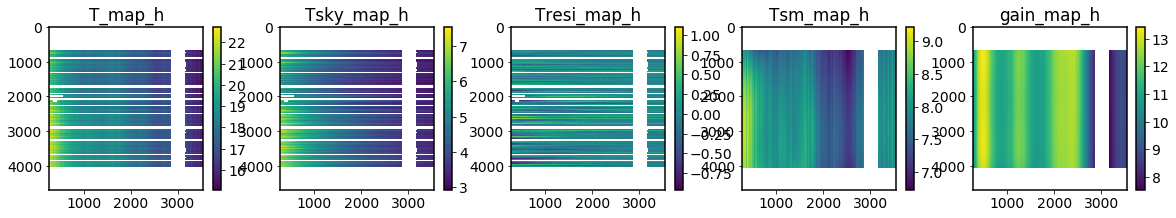

In [15]:
ch_e=3547 #UHF_band
l=[T_map_h,Tsky_map_h,Tresi_map_h,Tsm_map_h,gain_map_h]
l_str=['T_map_h','Tsky_map_h','Tresi_map_h','Tsm_map_h','gain_map_h']
plt.figure(figsize=(20,3))
for l_i in range(len(l)):
    a=l[l_i]
    plt.subplot(1,len(l),l_i+1)
    plt.title(l_str[l_i])
    plt.imshow(a,aspect='auto')
    plt.xlim(272,ch_e)
    plt.colorbar()
plt.show()

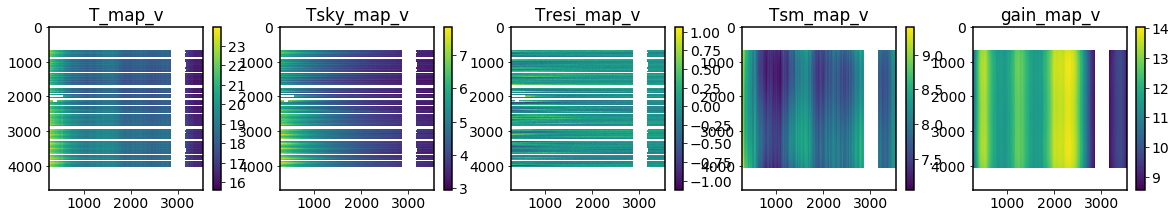

In [16]:
l=[T_map_v,Tsky_map_v,Tresi_map_v,Tsm_map_v,gain_map_v]
l_str=['T_map_v','Tsky_map_v','Tresi_map_v','Tsm_map_v','gain_map_v']
plt.figure(figsize=(20,3))
for l_i in range(len(l)):
    a=l[l_i]
    plt.subplot(1,len(l),l_i+1)
    plt.title(l_str[l_i])
    plt.imshow(a,aspect='auto')
    plt.xlim(272,ch_e)
    plt.colorbar()
plt.show()

In [17]:
assert((T_map_h.mask==Tresi_map_h.mask).all()==True)
assert((T_map_v.mask==Tresi_map_v.mask).all()==True)
div=T_map_h/T_map_v
mask_clean=div.mask.copy()
mask_clean_backup=mask_clean.copy()

In [18]:
l=[T_map_h,T_map_v,Tresi_map_h,Tresi_map_v,Tsm_map_h,Tsm_map_v,gain_map_h,gain_map_v]
l_copy=[T_map_h.copy(),T_map_v.copy(),Tresi_map_h.copy(),Tresi_map_v.copy(),Tsm_map_h.copy(),Tsm_map_v.copy(),gain_map_h.copy(),gain_map_v.copy()]

l_str=[r'$T_{cal}(\nu)$'+', pol=HH',r'$T_{cal}(\nu)$'+', pol=VV',r'$T_{res}(\nu)$'+', pol=HH',r'$T_{res}(\nu)$'+', pol=VV',
       r'$T_{rec}(\nu)$'+', pol=HH',r'$T_{rec}(\nu)$'+', pol=VV','gain'+r'$(\nu)$'+', pol=HH','gain'+r'$(\nu)$'+', pol=VV']

In [ ]:
del_point0,del_point1,del_point2,del_point3,del_point4,del_point5,del_point6,del_point7=[],[],[],[],[],[],[],[]


In [ ]:
#####filter######
niter=6

plt.figure(figsize=(14,len(l)*niter*1.6))
plt.subplots_adjust (wspace=0.2, hspace=0.35) 
for i in range(niter):
    print ('> The iteration '+str(i+1)+' is in progress...')
    mask_clean2=mask_clean.copy()
    
    del_point=[]
    
    for l_i in range(len(l)):
        a=l[l_i]
        plt.subplot(len(l)/2*niter,2,i*len(l)+l_i+1)
        a_ch=np.ma.mean(np.ma.array(a,mask=mask_clean),axis=0)
        plt.plot(freqs/1e6,a_ch,'g.', ms=4)
        if l_i !=2 and l_i!=3:
            plt.ylim(a_ch.min()*0.95,a_ch.max()*1.05)
        
        try:
            ax1=kf.curve_Rbf_filter_ma_array(range(272,2869),a_ch[272:2869],sigma=4.)
            #ax1=kf.curve_filter_ma_array(range(272,2869),a_ch[272:2869],sigma=4.)
            plt.plot(freqs[ax1]/1e6,a_ch[ax1],'.',color='r',ms=10) #deleted data
            mask_clean2[:,ax1]=True ###apply to the mask
            del_point+=list(ax1)
        except:
            ax1=[]
            print ('* 272-2869 filter not applied')
        #'''
        try:
            ax2=kf.curve_Rbf_filter_ma_array(range(3133,3547),a_ch[3133:3547],sigma=4.)
            #ax2=kf.curve_filter_ma_array(range(3133,3547),a_ch[3133:3547],sigma=4.)
            plt.plot(freqs[ax2]/1e6,a_ch[ax2],'.',color='r',ms=10) #deleted data
            mask_clean2[:,ax2]=True ###apply to the mask
            del_point+=list(ax2)
        except:
            ax2=[]
            print ('* 3133-3547 filter not applied')
        
        try:    
            ax3=kf.curve_Rbf_filter_ma_array(range(272,3547),a_ch[272:3547],sigma=4.)
            #ax3=kf.curve_filter_ma_array(range(272,3547),a_ch[272:3547],sigma=4.,k=1)
            plt.plot(freqs[ax3]/1e6,a_ch[ax3],'.',color='r',ms=10) #deleted data
            mask_clean2[:,ax3]=True ###apply to the mask
            del_point+=list(ax3)
        except:
            ax3=[]
            print ('* 272-3547 filter not applied')
        #'''
        if l_i==0:
            del_point0+=list(ax1)+list(ax2)+list(ax3)
        if l_i==1:
            del_point1+=list(ax1)+list(ax2)+list(ax3)
        if l_i==2:
            del_point2+=list(ax1)+list(ax2)+list(ax3)
        if l_i==3:
            del_point3+=list(ax1)+list(ax2)+list(ax3)
        if l_i==4:
            del_point4+=list(ax1)+list(ax2)+list(ax3)
        if l_i==5:
            del_point5+=list(ax1)+list(ax2)+list(ax3)
        if l_i==6:
            del_point6+=list(ax1)+list(ax2)+list(ax3)
        if l_i==7:
            del_point7+=list(ax1)+list(ax2)+list(ax3)
    
        
        plt.title('time mean '+ l_str[l_i]+', iter= '+str(i+1))
        
        if (l_i+2) % 2 == 0 and (l_i+1) % 7 !=0:
            plt.ylabel('Temperature (K)')
            
        if (l_i+1) % 7 ==0:
            plt.ylabel('gain')    
            
            
        if (l_i+2) % 8 == 0 or (l_i+1) % 8 == 0:
            plt.xlabel('Frequency (MHz)')
            
    print ('masks before and after filter are same:',)
    print ((mask_clean==mask_clean2).all())
    mask_clean=mask_clean2.copy()
    
    print (str(len(set(del_point))) + ' channels masked by '+str(len(del_point))+' times')
    if len(del_point)==0:
        print ('***filter done after iter time '+str(i+1)) 
        break
#plt.savefig(output_file+'F_'+fname+'_'+ant+'_ch_filter_iter'+str(i+1)+'.pdf', bbox_inches='tight')
plt.show()

> The iteration 1 is in progress...
masks before and after filter are same:
False
21 channels masked by 75 times
> The iteration 2 is in progress...
masks before and after filter are same:
False
12 channels masked by 46 times
> The iteration 3 is in progress...
masks before and after filter are same:
False
12 channels masked by 45 times
> The iteration 4 is in progress...
masks before and after filter are same:
False
12 channels masked by 42 times
> The iteration 5 is in progress...


In [ ]:
print (del_point0)
print (del_point1)
print (del_point2)
print (del_point3)
print (del_point4)
print (del_point5)
print (del_point6)
print (del_point7)

In [ ]:
del_point_all=del_point0+del_point1+del_point2+del_point3+del_point4+del_point5+del_point6+del_point7
del_point_all=list(set(del_point_all))
print (len(del_point_all))

In [ ]:
plt.figure(figsize=(14,80))
plt.subplots_adjust (wspace=0.2, hspace=0.3) 

for l_i in range(len(l)):
    a=l[l_i]
    plt.subplot(len(l)/2*niter,2,i*len(l)+l_i+1)
    
    
    if l_i==0:
        del_point_plot=del_point0
    if l_i==1:
        del_point_plot=del_point1
    if l_i==2:
        del_point_plot=del_point2
    if l_i==3:
        del_point_plot=del_point3
    if l_i==4:
        del_point_plot=del_point4
    if l_i==5:
        del_point_plot=del_point5
    if l_i==6:
        del_point_plot=del_point6
    if l_i==7:
        del_point_plot=del_point7
        
    a_ch=np.ma.mean(a,axis=0) #raw
    plt.plot(freqs[del_point_all]/1e6,a_ch[del_point_all],'.',color='gold',ms=6) #all deleted data
    plt.plot(freqs[del_point_plot]/1e6,a_ch[del_point_plot],'.',color='r',ms=6) #deleted data
    
    a_ch1=np.ma.mean(np.ma.array(a,mask=mask_clean),axis=0) #clean 
    plt.plot(freqs/1e6,a_ch1,'.', ms=4) #clean data
    
    if l_i !=2 and l_i!=3:
        plt.ylim(a_ch.min()*0.95,a_ch.max()*1.05)
 
    plt.title('time mean '+ l_str[l_i])

    if (l_i+2) % 2 == 0 and (l_i+1) % 7 !=0:
        plt.ylabel('Temperature (K)')

    if (l_i+1) % 7 ==0:
        plt.ylabel('gain')    

    if (l_i+2) % 8 == 0 or (l_i+1) % 8 == 0:
        plt.xlabel('Frequency (MHz)')
        
    if l_i==1:
        plt.legend(['deleted data due to other parameters', 'deleted data due to this parameter','clean data'], fontsize=11.5)
#plt.savefig(output_file+'F_'+fname+'_'+ant+'_ch_filter_final.png', bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=(14,80))
plt.subplots_adjust (wspace=0.2, hspace=0.3) 

for l_i in range(len(l)):
    a=l[l_i]
    plt.subplot(len(l)/2*niter,2,i*len(l)+l_i+1)
          
    a_ch1=np.ma.mean(np.ma.array(a,mask=mask_clean),axis=0) #clean 
    plt.plot(freqs/1e6,a_ch1,'.', ms=4) #clean data

    a_ch=np.ma.mean(a,axis=0) #raw
    plt.plot(freqs[ch_tower]/1e6,a_ch[ch_tower],'x',color='magenta')     
    
    if l_i !=2 and l_i!=3:
        plt.ylim(a_ch.min()*0.95,a_ch.max()*1.05)
 
    plt.title('time mean '+ l_str[l_i])

    if (l_i+2) % 2 == 0 and (l_i+1) % 7 !=0:
        plt.ylabel('Temperature (K)')

    if (l_i+1) % 7 ==0:
        plt.ylabel('gain')    

    if (l_i+2) % 8 == 0 or (l_i+1) % 8 == 0:
        plt.xlabel('Frequency (MHz)')
        
    if l_i==1:
        plt.legend(['clean data','deleted data due to signal tower'], fontsize=11.5)
#plt.savefig(output_file+'F_'+fname+'_'+ant+'_ch_filter_final.png', bbox_inches='tight')
plt.show()

In [ ]:
mask_clean[:,ch_tower]=True

In [ ]:
plt.figure(figsize=(14,80))
plt.subplots_adjust (wspace=0.2, hspace=0.3) 

for l_i in range(len(l)):
    a=l[l_i]
    plt.subplot(len(l)/2*niter,2,i*len(l)+l_i+1)
          
    a_ch1=np.ma.mean(np.ma.array(a,mask=mask_clean),axis=0) #clean 
    plt.plot(freqs/1e6,a_ch1,'.', ms=4) #clean data

   
    if l_i !=2 and l_i!=3:
        plt.ylim(a_ch1.min()*0.95,a_ch1.max()*1.05)
 
    plt.title('time mean '+ l_str[l_i])

    if (l_i+2) % 2 == 0 and (l_i+1) % 7 !=0:
        plt.ylabel('Temperature (K)')

    if (l_i+1) % 7 ==0:
        plt.ylabel('gain')    

    if (l_i+2) % 8 == 0 or (l_i+1) % 8 == 0:
        plt.xlabel('Frequency (MHz)')
        
    if l_i==1:
        plt.legend(['clean data'], fontsize=11.5)
plt.savefig(output_file+'F_'+fname+'_'+ant+'_ch_filter_final_clean.png', bbox_inches='tight')
plt.show()

In [ ]:
l=[Tsky_map_h, Tsky_map_v, Tresi_map_h, Tresi_map_v]
l_str=['Tsky_map_h', 'Tsky_map_v', 'Tresi_map_h', 'Tresi_map_v']
plt.figure(figsize=(9,7))
for l_i in range(len(l)):
    a=l[l_i]
    plt.subplot(len(l)/2,2,l_i+1)
    plt.title(l_str[l_i])
    plt.imshow(np.ma.array(a,mask=mask_clean),aspect='auto')
    plt.xlim(272,ch_e)
    plt.colorbar()
plt.show()

In [ ]:
def mask2int(mask):
    int_mask=np.zeros(np.shape(mask))
    #print (int_mask)
    int_mask[np.where(mask==True)]=1
    int_mask[np.where(mask==False)]=0
    return int_mask

In [ ]:
plt.figure(figsize=(12,4.5))
plt.subplot(121)
plt.imshow(mask2int(mask_clean_backup),aspect='auto')
plt.xlim(272,ch_e)
plt.colorbar()
plt.subplot(122)
plt.imshow(mask2int(mask_clean),aspect='auto')
plt.xlim(272,ch_e)
plt.colorbar()
plt.show()

In [ ]:
Tsky_map_h=np.ma.array(Tsky_map_h,mask=mask_clean)
Tsky_map_v=np.ma.array(Tsky_map_v,mask=mask_clean)

Tresi_map_h=np.ma.array(Tresi_map_h,mask=mask_clean)
Tresi_map_v=np.ma.array(Tresi_map_v,mask=mask_clean)


In [ ]:
Tsky_map,Tsky_ratio=cal_map_I(Tsky_map_h, Tsky_map_v)
Tresi_map=(Tresi_map_h+Tresi_map_v)/2.
assert((Tsky_map.mask==Tresi_map.mask).all()==True)

In [ ]:
plt.figure(figsize=(14,5.4))
#plt.subplots_adjust (wspace=0.2, hspace=0) 
plt.subplot(121)
plt.imshow(Tsky_map[:,272:3547],aspect='auto',extent=(freqs[272]/1e6,freqs[3547]/1e6,len(timestamps)*2,0))
plt.xlabel('Frequency (MHz)')
plt.ylabel('time (s)')
#plt.xlim(550,ch_e)
if fname=='1551055211':
    plt.title('$I_{sky}$, '+ant+' of obs190225', y=1.15)
clb = plt.colorbar()
clb.set_label('Kelvin', labelpad=-35, y=1.06, rotation=0, fontsize=12)
plt.twiny()
plt.imshow(Tsky_map[:,272:3547], aspect='auto',extent=(272,3547,len(timestamps)*2,0))
plt.xlabel('channel')
plt.subplot(122)
plt.imshow(Tresi_map[:,272:3547],aspect='auto',vmax=0.3, extent=(freqs[272]/1e6,freqs[3547]/1e6,len(timestamps)*2,0))
plt.xlabel('Frequency (MHz)')
plt.ylabel('time (s)')
#plt.xlim(550,ch_e)
if fname=='1551055211':
    plt.title('$I_{resi}$, '+ant+' of obs190225', y=1.15)
clb = plt.colorbar()
clb.set_label('Kelvin', labelpad=-45, y=1.06, rotation=0, fontsize=12)
plt.twiny()
plt.imshow(Tresi_map[:,272:3547], aspect='auto',vmax=0.3, extent=(272,3547,len(timestamps)*2,0))
plt.xlabel('channel')
plt.savefig(output_file+'F_'+fname+'_'+ant+'_Inten.png', bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=(5.8,12))
plt.subplots_adjust(wspace=0,hspace=.45)
plt.subplot(211)
plt.imshow(Tsky_map[:,272:3547],aspect='auto',extent=(freqs[272]/1e6,freqs[3547]/1e6,len(timestamps)*2,0))
plt.xlabel('Frequency (MHz)')
plt.ylabel('time (s)')
#plt.xlim(550,ch_e)
if fname=='1551055211':
    plt.title('$T_{sky}$, '+ant+' of obs190225', y=1.15)
clb = plt.colorbar()
clb.set_label('Kelvin', labelpad=-33, y=1.06, rotation=0, fontsize=12)
plt.twiny()
plt.imshow(Tsky_map[:,272:3547], aspect='auto',extent=(272,3547,len(timestamps)*2,0))
plt.xlabel('channel')
plt.subplot(212)
plt.imshow(Tresi_map[:,272:3547],aspect='auto',vmax=0.3, extent=(freqs[272]/1e6,freqs[3547]/1e6,len(timestamps)*2,0))
plt.xlabel('Frequency (MHz)')
plt.ylabel('time (s)')
#plt.xlim(550,ch_e)
if fname=='1551055211':
    plt.title('$T_{res}$, '+ant+' of obs190225', y=1.15)
clb = plt.colorbar()
clb.set_label('Kelvin', labelpad=-45, y=1.06, rotation=0, fontsize=12)
plt.twiny()
plt.imshow(Tresi_map[:,272:3547], aspect='auto',vmax=0.3, extent=(272,3547,len(timestamps)*2,0))
plt.xlabel('channel')
#plt.savefig(output_file+'F_'+fname+'_'+ant+'_Inten.pdf', bbox_inches='tight')
plt.show()

In [ ]:
assert((Tsky_ratio.mask==mask_clean).all()==True)
print (np.ma.max(Tsky_ratio))

In [ ]:
plt.figure(figsize=(6,4.5))
plt.imshow(Tsky_ratio,aspect='auto')
plt.xlim(272,ch_e)
plt.title(fname+'_'+ant+'_Tsky_ratio')
plt.colorbar()
#plt.savefig(output_file+fname+'_'+ant+'_Tsky_ratio.png')
plt.show()

In [ ]:
bins=200

plt.figure(figsize=(10,3))
max=np.sum(Tsky_ratio.mask==False)/bins
median=np.ma.median(Tsky_ratio)
plt.hist(Tsky_ratio[~Tsky_ratio.mask],bins=bins,log=True)
plt.plot([median,median],[0,max],'g-',lw=5)
plt.xlabel('Tsky ratio')
plt.ylabel('Count')
plt.title(fname+'_'+ant+', bins'+str(bins))
#plt.savefig(output_file+fname+'_'+ant+'_Tsky_ratio_his.png')
plt.show()

In [46]:
data=kio.load_data(fname)
dp_tt,dp_ss,dp_f,dp_w, dp_t,dp_s,dp_slew,dp_stop=kl.cal_dp_label(data,flags,ant,pol,ch_ref,ang_deg)

UnboundLocalError: local variable 'data' referenced before assignment

<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>


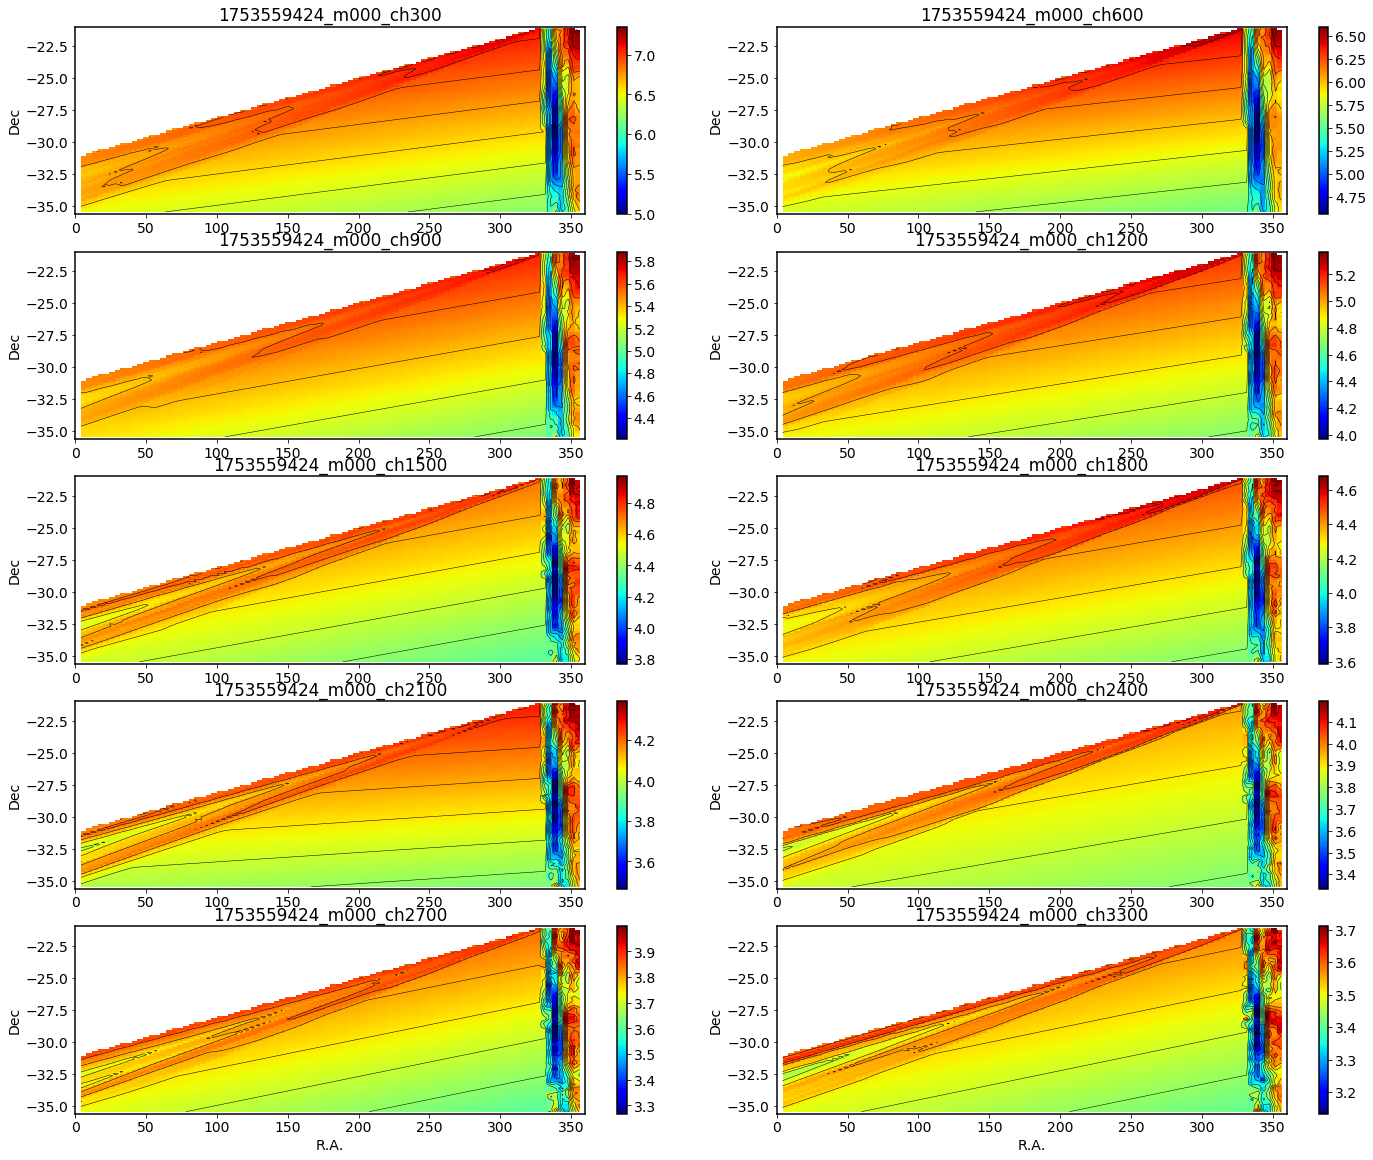

In [37]:
#for ch_plot in list(range(272,2869))+list(range(3133,3547)):
ch_plot_list=[300,600,900,1200,1500,1800,2100,2400,2700,3300]
plt.figure(figsize=(24,20))
plt.subplots_adjust (wspace=0.1, hspace=0.2) 
for i in range(len(ch_plot_list)):
    ch_plot1=ch_plot_list[i]
    p_data=Tsky_map[:,ch_plot1]
    plt.subplot(5,2,i+1)
    if (p_data.mask==True).all()==False:
        kv.plot_data(ra,dec, p_data,gsize=90)
    if i>len(ch_plot_list)-3:
        plt.xlabel('R.A.')
    plt.ylabel('Dec')
    plt.title(fname+'_'+ant+'_ch'+str(ch_plot1))
#plt.savefig(output_file+fname+'_'+ant+'_Tsky_map.png')
plt.show()


<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>


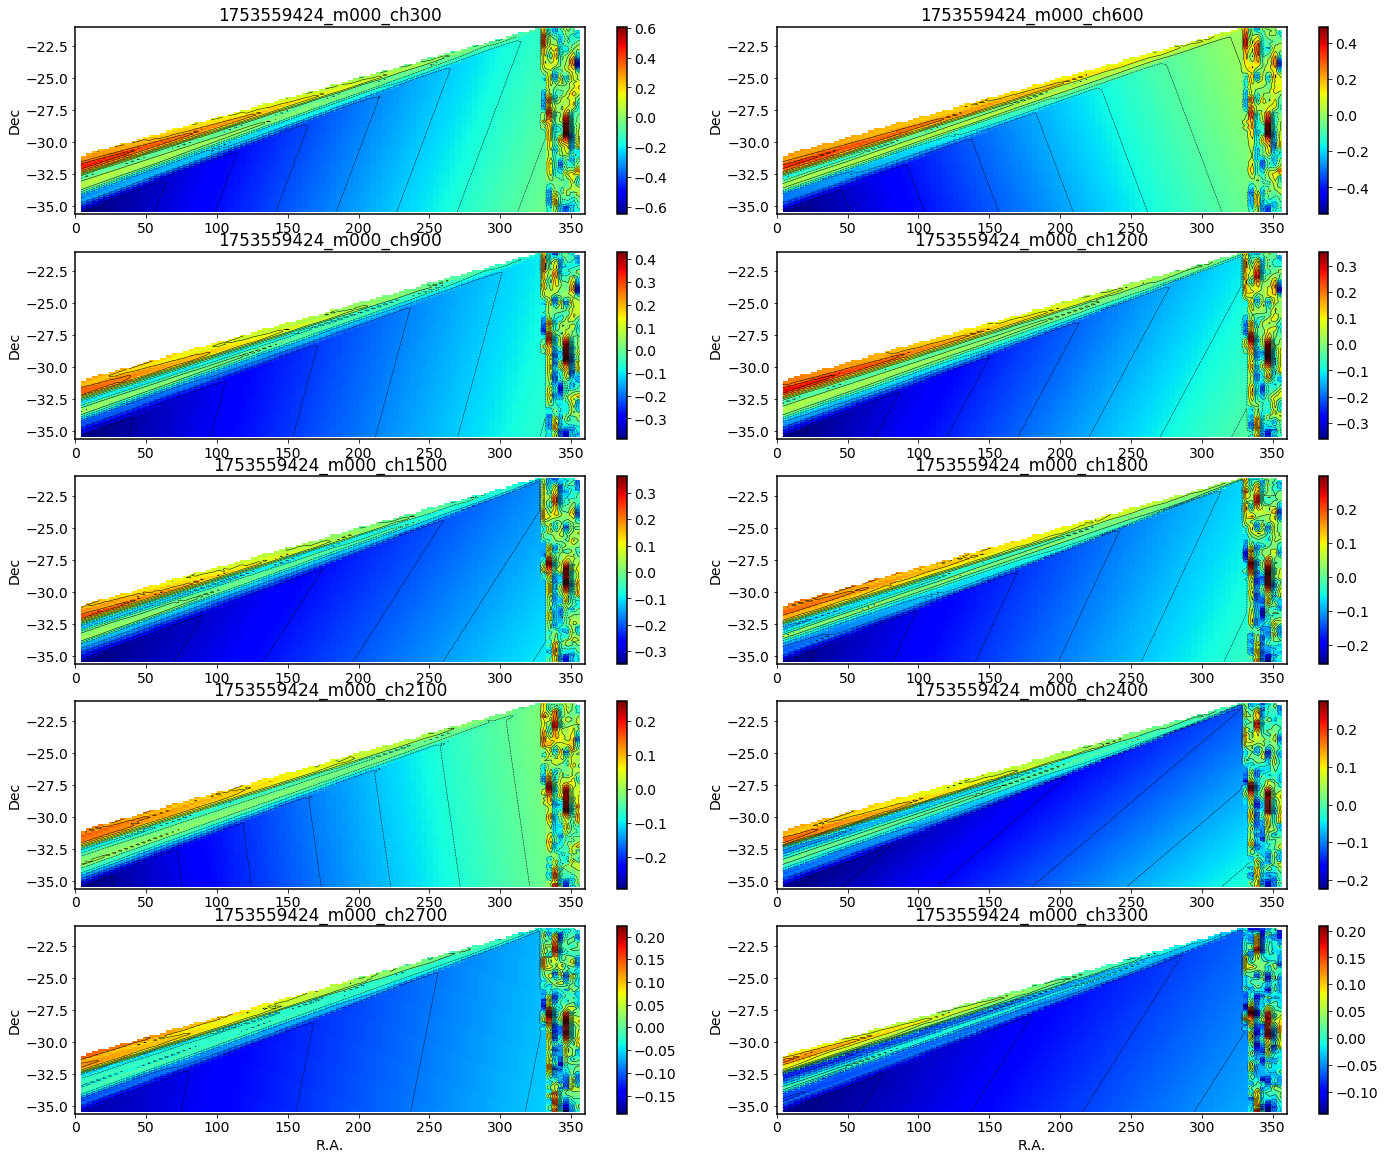

In [38]:
plt.figure(figsize=(24,20))
plt.subplots_adjust (wspace=0.1, hspace=0.2) 
for i in range(len(ch_plot_list)):
    ch_plot1=ch_plot_list[i]
    p_data=Tresi_map[:,ch_plot1]
    plt.subplot(5,2,i+1)
    if (p_data.mask==True).all()==False:
        kv.plot_data(ra,dec, p_data,gsize=90)
    if i>len(ch_plot_list)-3:
        plt.xlabel('R.A.')
    plt.ylabel('Dec')
    plt.title(fname+'_'+ant+'_ch'+str(ch_plot1))
    #plt.plot(p_radec[:,0],p_radec[:,1],'mo')
#plt.savefig(output_file+fname+'_'+ant+'_Tresi_map.png')
plt.show()


In [39]:
ch_plot=3300
plot_gsize=90

<class 'numpy.ma.core.MaskedArray'>


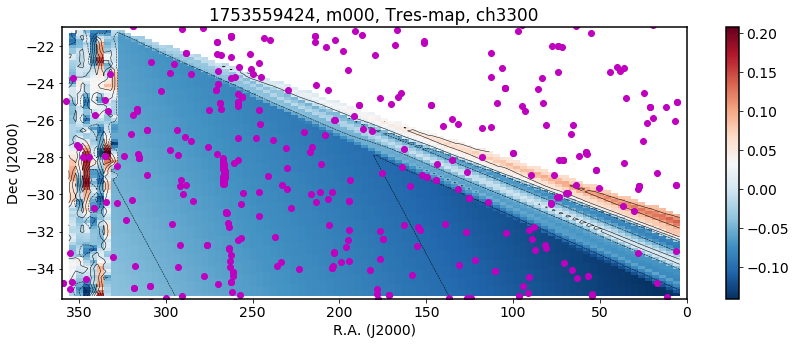

In [40]:
plt.figure(figsize=(14,5))
ax=plt.subplot()
p_data=Tresi_map[nd_s0,ch_plot]
if (p_data.mask==True).all()==False:
    kv.plot_mdata(ra[nd_s0],dec[nd_s0], p_data,gsize=plot_gsize, grid_method='linear', levels=6, x_mask=1, y_mask=2, cmap=kv.cmap2())
ax.invert_xaxis()
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
#plt.text(146.3, 8.5, 'Kelvin', rotation=0)
plt.xlabel('R.A. (J2000)')
plt.ylabel('Dec (J2000)')
#plt.savefig('F_calibrated_map.pdf', bbox_inches='tight')
plt.title(fname+', '+ant+', Tres-map, ch'+str(ch_plot))
plt.savefig(output_file+'F_'+fname+'_'+ant+'_Tres.png', bbox_inches='tight')
plt.show()


In [41]:
assert((Tsky_map.mask==mask_clean).all()==True)
assert((Tresi_map.mask==mask_clean).all()==True)
assert((Tsky_ratio.mask==mask_clean).all()==True)

d={}
d['Tsky_map']=Tsky_map
d['Tresi_map']=Tresi_map
d['Tsky_ratio']=Tsky_ratio

d['timestamps']=timestamps
d['ra']=ra
d['dec']=dec
#assert((nd_s0_h==nd_s0_v).all())
d['nd_s0_h']=nd_s0_h
d['nd_s0_v']=nd_s0_v
fs=open(output_file+str(fname)+'_'+str(ant)+'_level4_data','wb')
pickle.dump(d,fs,protocol=2)
fs.close()

d1={}

d1['Inten_mask']=mask_clean
fs=open(output_file+str(fname)+'_'+str(ant)+'_level4_mask','wb')
pickle.dump(d1,fs,protocol=2)
fs.close()

In [42]:
print ('end @ ' + time.asctime(time.localtime(time.time())) +'#')

end @ Wed Nov 12 05:37:44 2025#


In [43]:
end

NameError: name 'end' is not defined

# reload data to check

In [ ]:
print ('start @ ' + time.asctime(time.localtime(time.time())) +'...')

In [ ]:
d2=pickle.load(open('/idia/projects/hi_im/raw_vis/MeerKLASS2021/level4/data/'+fname+'_'+ant+'_level4_data','rb'), encoding='latin-1')
assert((d2['Tsky_map'].mask==d2['Tresi_map'].mask).all()==True)

In [ ]:
print (d2.keys())

In [ ]:
print (d2['Tsky_ratio'])

In [ ]:
assert((d2['Tsky_map'].data==Tsky_map.data).all()==True)
assert((d2['Tsky_map'].mask==Tsky_map.mask).all()==True)

assert((d2['Tresi_map'].data==Tresi_map.data).all()==True)
assert((d2['Tresi_map'].mask==Tresi_map.mask).all()==True)

print ('# all same!')

In [ ]:
print (d2['timestamps'])

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.imshow(d2['Tsky_map'],aspect='auto')
plt.colorbar()
plt.subplot(122)
plt.imshow(d2['Tresi_map'],aspect='auto')
plt.colorbar()
plt.show()

In [ ]:
d3=pickle.load(open('/idia/projects/hi_im/raw_vis/MeerKLASS2021/level4/mask/'+fname+'_'+ant+'_level4_mask','rb'))


In [ ]:
print (d3.keys())

In [ ]:
assert((d3['Inten_mask']==mask_clean).all()==True)

In [ ]:
plt.figure(figsize=(6,4.5))
plt.imshow(mask2int(d3['Inten_mask']),aspect='auto')
plt.xlim(550,ch_e)
plt.colorbar()
plt.show()

In [ ]:
print ('end @ ' + time.asctime(time.localtime(time.time())) +'#')